In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Using gpu
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [23]:
train_df = pd.read_csv(
    'train.csv',
    usecols=[1, 2, 3, 4, 5],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

test_df =  pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

oil_df =  pd.read_csv(
    'oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
) 

holidays_events_df = pd.read_csv(
    'holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
    },
    parse_dates = ['date'],
    infer_datetime_format = True,
).rename(columns = {'type':'holiday_type'})

stores_df = pd.read_csv(
    'stores.csv',
    dtype = {
        'store_nbr': 'category',
        'city': 'category',
        'state': 'category',
        'type': 'category',
        'cluster': 'category'
    }).rename(columns ={'type':'store_type'})

In [24]:
# show holidays for only the relevant time periods
holidays_events_df = holidays_events_df.loc[holidays_events_df['date'] < pd.to_datetime('2017/09/01')]  # less than last date in test data
holidays_events_df = holidays_events_df.loc[holidays_events_df['date'] >= pd.to_datetime('2013/01/01')] # greater than or equal to first day in train


## need to join the tables first as there are duplicate dates for holidays at different locales



In [25]:
stores_df = stores_df.drop(columns=['store_type', 'cluster'])

In [26]:
train_df = train_df.merge(stores_df, on = 'store_nbr')

# Holiday/Store Data

Ultimately, did not use the cells below account for holidays

In [8]:
## Create a new column affected_by_holiday with values np.nan
# train_df['affected_by_holiday'] = np.nan

In [9]:
## for loop to join , takes way too long as I don't know how to implement a better way

#for i in range(holidays_events_df.shape[0]):
#    j_index = np.where( (train_df['date'] == holidays_events_df.iloc[i].date) == True)[0]
#    for j in j_index:
#        if (train_df.city[j] == holidays_events_df.iloc[i].locale_name or train_df.state[j] == holidays_events_df.iloc[i].locale_name):
#            train_df['affected_by_holiday'].iloc[j] = True
#        else:
#            train_df['affected_by_holiday'].iloc[j] = False

In [10]:
#full_df = pd.concat([train_df, test_df], sort=True)

In [11]:
#full_df = full_df.merge(stores_df, how = 'left', on = 'store_nbr')
#full_df = full_df.merge(oil_df, how = 'left', on = 'date')
#full_df = full_df.merge(holidays_events_df, how = 'left', on = 'date')

# Filling NA Values

In [27]:
## oil is missing dates because trading does not happen on weekends, but we we need this to match our data for the LSTM
## so we can interpret the weekends oil price with interpolate

# fill missing dates with settting date as index and reindexing with date range from beginning of train set to end of test set
idx = pd.date_range(oil_df.date.min(),oil_df.date.max())
oil_df = oil_df.set_index('date').reindex(idx)

# fill empty oil prices using interpolation with method time
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method = 'time', limit_direction='both')
oil_df = oil_df.rename_axis('date').reset_index()    # make date a column again 

In [28]:
## testing without holiday events


train_df = train_df.merge(oil_df, on = 'date')
test_df = test_df.merge(oil_df, on="date")

In [14]:
#full_df['dcoilwtico'] = full_df['dcoilwtico'].interpolate(limit_direction='both')
#full_df['holiday_type'] = full_df['holiday_type'].fillna('Work Day')
#full_df['transferred'] = full_df['transferred'].fillna(False)

# Converting data to supervised learning


In [46]:
# ref: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, futureArr=None, targetCol=None, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in df.columns]
        
    # forecast sequence (t, t+1, ... t+n)    
    if futureArr != None:
        for i in range(0, n_out):
            for futureCol in futureArr:
                cols.append(df.shift(-i)[futureCol])
                if i == 0:
                    names += [('%s(t)' % (futureCol))]
                else:
                    names += [('%s(t+%d)' % (futureCol, i))]
    
    for i in range(0, n_out):
        if targetCol == None:
            cols.append(df.shift(-i))
            if i == 0:
                names += [('%s(t)' % (j)) for j in df.columns]
            else:
                names += [('%s(t+%d)' % (j, i)) for j in df.columns]
        else:
            cols.append(df.shift(-i)[targetCol])
            if i == 0:
                names += [('%s(t)' % (targetCol))]
            else:
                names += [('%s(t+%d)' % (targetCol, i))]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
store_nbrs = train_df['store_nbr'].unique()
family_types = train_df['family'].unique()


In [48]:
for store_nbr_type in store_nbrs:
    for family_type in family_types:
        
        train_df1 = train_df[(train_df["store_nbr"] == store_nbr_type) & (train_df["family"] == family_type)]
        
        train_df1 = train_df1.reset_index()
        train_df1 = train_df1.drop(columns = ['index', "date", "store_nbr", "family"])
        
   
        test_df1 = test_df[(test_df["store_nbr"] == store_nbr_type) & (test_df["family"] == family_type)]
        test_df1 = test_df1.drop(columns = ["date", "store_nbr", "family"])
        break
    break

In [49]:
full_df = pd.concat([train_df1, test_df1]).drop(columns=['id', 'city', 'state'])
full_df

,sales,onpromotion,dcoilwtico
0,0.0,0,93.140000
1,2.0,0,93.140000
2,3.0,0,92.970000
3,3.0,0,93.120000
4,5.0,0,93.146667
...,...,...,...
19602,NaN,0,46.816667
21384,NaN,0,46.400000
23166,NaN,0,46.460000
24948,NaN,0,45.960000


In [50]:
features = full_df.columns


## scales all the data in each column 0 to 1
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))

full_df = scaler.fit_transform(full_df)

full_df=pd.DataFrame(full_df, columns = features)

full_df

,sales,onpromotion,dcoilwtico
0,0.000000,0.0,0.792965
1,0.105263,0.0,0.792965
2,0.157895,0.0,0.790951
3,0.157895,0.0,0.792728
4,0.263158,0.0,0.793044
...,...,...,...
1695,NaN,0.0,0.244305
1696,NaN,0.0,0.239370
1697,NaN,0.0,0.240081
1698,NaN,0.0,0.234158


In [51]:
futureArr = ['onpromotion', 'dcoilwtico']

series_to_supervised(full_df, 5, 2, futureArr = futureArr, targetCol = 'sales')

,sales(t-5),onpromotion(t-5),dcoilwtico(t-5),sales(t-4),onpromotion(t-4),dcoilwtico(t-4),sales(t-3),onpromotion(t-3),dcoilwtico(t-3),sales(t-2),...,dcoilwtico(t-2),sales(t-1),onpromotion(t-1),dcoilwtico(t-1),onpromotion(t),dcoilwtico(t),onpromotion(t+1),dcoilwtico(t+1),sales(t),sales(t+1)
5,0.000000,0.0,0.792965,0.105263,0.0,0.792965,0.157895,0.0,0.790951,0.157895,...,0.792728,0.263158,0.0,0.793044,0.0,0.793359,0.0,0.793675,0.105263,0.000000
6,0.105263,0.0,0.792965,0.157895,0.0,0.790951,0.157895,0.0,0.792728,0.263158,...,0.793044,0.105263,0.0,0.793359,0.0,0.793675,0.0,0.793794,0.000000,0.105263
7,0.157895,0.0,0.790951,0.157895,0.0,0.792728,0.263158,0.0,0.793044,0.105263,...,0.793359,0.000000,0.0,0.793675,0.0,0.793794,0.0,0.792254,0.105263,0.105263
8,0.157895,0.0,0.792728,0.263158,0.0,0.793044,0.105263,0.0,0.793359,0.000000,...,0.793675,0.105263,0.0,0.793794,0.0,0.792254,0.0,0.800900,0.105263,0.105263
9,0.263158,0.0,0.793044,0.105263,0.0,0.793359,0.000000,0.0,0.793675,0.105263,...,0.793794,0.105263,0.0,0.792254,0.0,0.800900,0.0,0.798413,0.105263,0.157895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.263158,0.0,0.276126,0.315789,0.0,0.275337,0.368421,0.0,0.274547,0.210526,...,0.270994,0.368421,0.0,0.277153,0.0,0.264716,0.0,0.267914,0.473684,0.052632
1679,0.315789,0.0,0.275337,0.368421,0.0,0.274547,0.210526,0.0,0.270994,0.368421,...,0.277153,0.473684,0.0,0.264716,0.0,0.267914,0.0,0.263098,0.052632,0.315789
1680,0.368421,0.0,0.274547,0.210526,0.0,0.270994,0.368421,0.0,0.277153,0.473684,...,0.264716,0.052632,0.0,0.267914,0.0,0.263098,0.0,0.258281,0.315789,0.052632
1681,0.210526,0.0,0.270994,0.368421,0.0,0.277153,0.473684,0.0,0.264716,0.052632,...,0.267914,0.315789,0.0,0.263098,0.0,0.258281,0.0,0.253464,0.052632,0.052632


# Splitting the Data

It is not trivial to perform cross-validation on time-series data as it does not make sense to use future values to forecast past values. 

Thus we will perform a one step ahead cross validation as described by Hyndman and Athanasopoulos. We will perform the model using different numbers of 'past_days'. We will try 7, 14, 30, 50, and 100 as the number of past days.

Because our approach is fitting different models for different combinations of store_nbr and family, we will only look at store_nbr 1 and family Automotive for learning purposes.


for past_days = 8, we had mse: 0.0190 in the training and val_mse: 0.0218 for validation

for past_days = 16, we had mse: 0.0190 for training and val_mse: 0.0218 for validation

for past_days = 32, we had mse: 0.0192 for training and val_mse: 0.0214 for validation

for past_days = 48, we had mse: 0.0194 for training and val_mse: 0.0214 for validation

for past_days = 100, we had mse: 0.0196 for training and val_mse: 0.0213 for validation


seeing these trends, we can say that ultimately, training using a higher number of past_days does not provide much benefit but does increase the number of trainable parameters. As such, we will stay with a smaller past_days. 


We will also opt to check the batch_size and the number of epochs ranging from (20, 150) for batch_size and (20,100) for epochs.

batch_size 50, epochs 20 = loss: 0.0189 - mse: 0.0189 - val_loss: 0.0221 - val_mse: 0.0220

batch_size 100, epochs 20 = loss: 0.0191 - mse: 0.0191 - val_loss: 0.0220 - val_mse: 0.0216

batch_size 150, epochs 20 = loss: 0.0191 - mse: 0.0189 - val_loss: 0.0220 - val_mse: 0.0214

batch_size 200, epochs 20 = loss: 0.0192 - mse: 0.0190 - val_loss: 0.0221 - val_mse: 0.0219

batch_size 150, epochs 50 =  loss: 0.0190 - mse: 0.0189 - val_loss: 0.0220 - val_mse: 0.0214

batch_size 150, epochs 100 = loss: 0.0190 - mse: 0.0189 - val_loss: 0.0221 - val_mse: 0.0215

Ranging the epochs did not have much of an effect. Even if we remove the stopping conditions, there is not enough variable change as the stopping condition already accounts for this, so keeping epochs at 20 is reasonable. We seem to have the best loss with batch_size = 150

In [52]:
past_days = 8
predict_days = 16

futureArr = ['onpromotion', 'dcoilwtico']
targetCol = 'sales'

train = series_to_supervised(full_df, past_days, predict_days, futureArr, targetCol)

values = train.values


## split into train and validation sets

split_ratio = 0.8

split_number = np.floor(len(train.index) * split_ratio)
split_number = np.int(split_number)
        
train = values[:split_number, :]
val = values[split_number:, :]

## split into input and outputs

train_x, train_y = train[:, :-predict_days], train[:, -predict_days:]
val_x, val_y = val[:, :-predict_days], val[:, -predict_days:]

## reshape input to be 3D [samples, timesteps, features]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))


prediction_data = series_to_supervised(full_df, past_days, predict_days, futureArr, targetCol, dropnan=False).values[-17:-16, :-predict_days]
prediction_data = prediction_data.reshape((prediction_data.shape[0], 1, prediction_data.shape[1]))

print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, prediction_data.shape)

(1328, 1, 56) (1328, 16) (333, 1, 56) (333, 16) (1, 1, 56)


In [53]:
len(train[1,:-16])

56

In [54]:
val_x

array([[[0.42105263, 0.        , 0.23806704, ..., 0.20916736,
         0.        , 0.19957361]],

       [[0.10526316, 0.        , 0.24612105, ..., 0.19957361,
         0.        , 0.20075802]],

       [[0.36842105, 0.        , 0.25405661, ..., 0.20075802,
         0.        , 0.20194244]],

       ...,

       [[0.52631579, 0.        , 0.23202653, ..., 0.26309764,
         0.        , 0.25828102]],

       [[0.42105263, 0.        , 0.23372419, ..., 0.25828102,
         0.        , 0.25346441]],

       [[0.        , 0.        , 0.23542185, ..., 0.25346441,
         0.        , 0.25322753]]])

In [59]:
# Model
model = keras.models.Sequential([
        keras.layers.LSTM(units=30, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(units=30, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.TimeDistributed(keras.layers.Dense(predict_days))
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse", "accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 30)             10440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 16)             496       
Total params: 18,256
Trainable params: 18,256
Non-trainable params: 0
_________________________________________________________________


In [60]:
early_stopping =  keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model_result = model.fit(train_x, train_y, epochs=100, batch_size=150, validation_data=(val_x, val_y), verbose=2, shuffle=False, callbacks=[early_stopping])

Epoch 1/100
9/9 - 1s - loss: 0.0442 - mse: 0.0438 - accuracy: 3.2944e-04 - val_loss: 0.0576 - val_mse: 0.0559 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 - 0s - loss: 0.0373 - mse: 0.0370 - accuracy: 3.7651e-04 - val_loss: 0.0495 - val_mse: 0.0480 - val_accuracy: 0.0000e+00
Epoch 3/100
9/9 - 0s - loss: 0.0315 - mse: 0.0312 - accuracy: 6.1182e-04 - val_loss: 0.0414 - val_mse: 0.0401 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 - 0s - loss: 0.0282 - mse: 0.0280 - accuracy: 6.5889e-04 - val_loss: 0.0356 - val_mse: 0.0345 - val_accuracy: 0.0000e+00
Epoch 5/100
9/9 - 0s - loss: 0.0267 - mse: 0.0265 - accuracy: 0.0016 - val_loss: 0.0328 - val_mse: 0.0317 - val_accuracy: 0.0000e+00
Epoch 6/100
9/9 - 0s - loss: 0.0258 - mse: 0.0256 - accuracy: 0.0029 - val_loss: 0.0313 - val_mse: 0.0304 - val_accuracy: 0.0000e+00
Epoch 7/100
9/9 - 0s - loss: 0.0247 - mse: 0.0245 - accuracy: 0.0032 - val_loss: 0.0301 - val_mse: 0.0292 - val_accuracy: 0.0000e+00
Epoch 8/100
9/9 - 0s - loss: 0.0238 - mse: 0.0237 - a

In [61]:
model.evaluate(val_x, val_y)

11/11 [==============================] - 0s 1ms/step - loss: 0.0217 - mse: 0.0217 - accuracy: 0.0000e+00


[0.02169995941221714, 0.02168872021138668, 0.0]

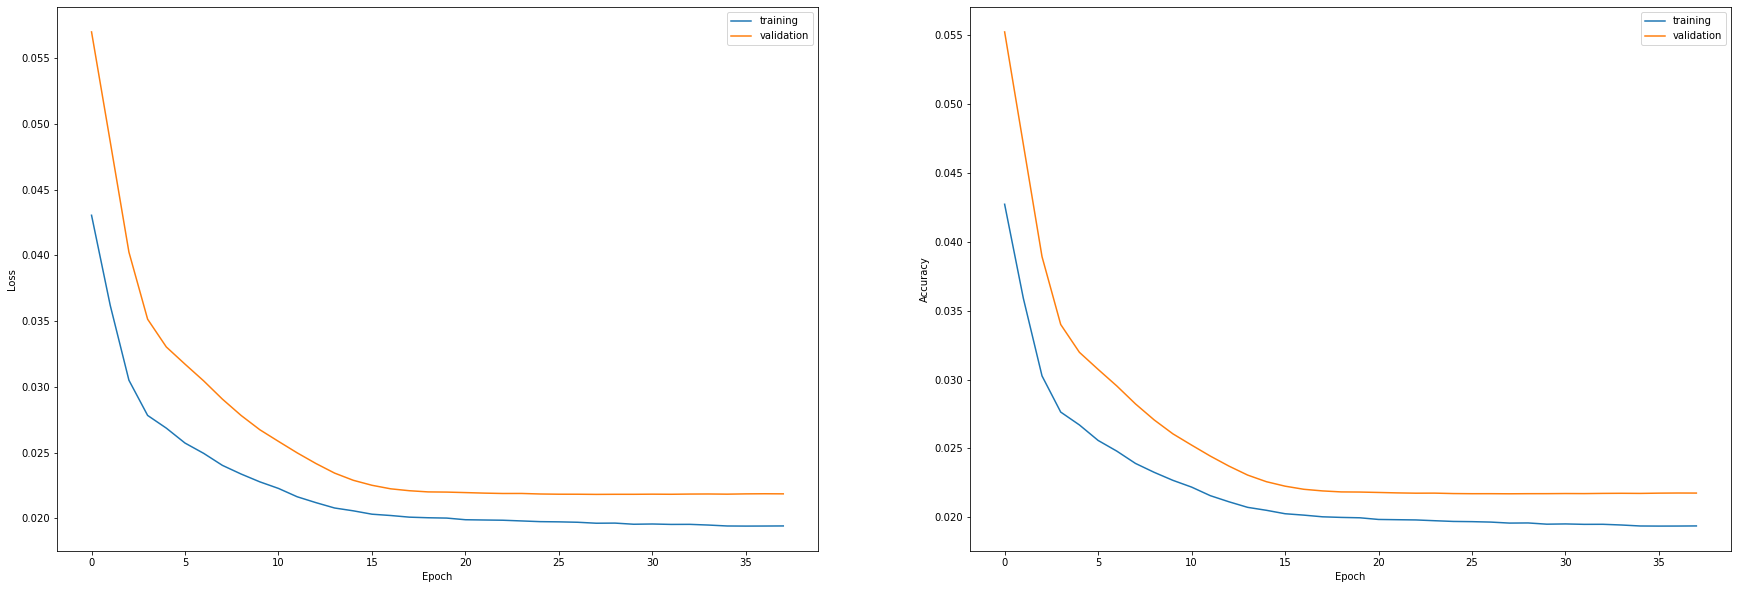

In [24]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(model_result.history["loss"], label="training")
plt.plot(model_result.history["val_loss"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_result.history["mse"], label="training")
plt.plot(model_result.history["val_mse"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [25]:
# predict the sales(t+1 to t+16) for our prediction data (which is the last sample))
prediction = model.predict(prediction_data)

#rescale our outputs
prediction = np.squeeze(prediction) / scaler.scale_[0]


#apply the predicted data to our test_dataframe of the respective store_type and family type
test_df1['sales'] = prediction

# Looping through each store_nbr, family combination

In [26]:
## putting it all together with each store_nbr and family

store_nbr_types = train_df["store_nbr"].unique()

family_types = train_df["family"].unique()

counter = 0 ## counter used to visit all store/type combinations


for store_nbr_type in store_nbr_types:
    for family_type in family_types:
        counter = counter + 1

        train_data = train_df[(train_df["store_nbr"] == store_nbr_type) & (train_df["family"] == family_type)]
        
        # reset the index so it doesnt mess up with total concatenated data, then drop
        train_data = train_data.reset_index()
        train_data = train_data.drop(columns = ["index", "date", "store_nbr", "family"])
        
        # test data for the respective store,family combination to fill sales      
        test_data = test_df[(test_df["store_nbr"] == store_nbr_type) & (test_df["family"] == family_type)]
        test_data = test_data.drop(columns = ["date", "store_nbr", "family"])
        
        # concat train and test data
        full_df = pd.concat([train_data, test_data]).drop(columns=["id", 'city', 'state'])
        
        # Normalization
        features = full_df.columns

        scaler = preprocessing.MinMaxScaler(feature_range = (0,1))

        full_df = scaler.fit_transform(full_df)

        full_df = pd.DataFrame(full_df, columns=feature_name)
        
        # number of days to forecast
        past_days = 8
        # number of days to predict
        predict_days = 16
        # what columns as features
        futureArr = ["onpromotion", "dcoilwtico"]
        # what column is target
        targetCol = "sales"

        train = series_to_supervised(full_df, past_days, predict_days, futureArr, targetCol)

        split_ratio = 0.8

        split_number = np.floor(len(train.index) * split_ratio)
        split_number = np.int(split_number)

        values = train.values


        # split into train and validation sets
        train = values[:split_number, :]
        val = values[split_number:, :]

        # split into input and outputs
        train_x, train_y = train[:, :-predict_days], train[:, -predict_days:]
        val_x, val_y = val[:, :-predict_days], val[:, -predict_days:]
        # reshape input to be 3D [samples, timesteps, features]
        train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
        val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

        # the use of (-17:-16 represents use ofdata in last 17 days)
        prediction_data = series_to_supervised(full_df, past_days, predict_days, futureArr, targetCol, dropnan=False).values[-17:-16, :-predict_days]
        prediction_data = prediction_data.reshape((prediction_data.shape[0], 1, prediction_data.shape[1]))
        
        model_result = model.fit(train_x, train_y, epochs=50, batch_size=150, validation_data=(val_x, val_y), verbose=0, shuffle=False, callbacks=[early_stopping])
        
        # Inference        
        prediction = model.predict(prediction_data)

        prediction = np.squeeze(prediction) / scaler.scale_[0]

        test_data["sales"] = prediction
        
        if counter == 1:
            submit_data = test_data
        else:
            submit_data = pd.concat([submit_data, test_data])
        
        if counter % 50 == 0:
            print(counter)
        
        
print("done!")

NameError: name 'feature_name' is not defined

# Saving the data to submission data

In [ ]:
submit_data.to_csv('submit_data.csv', index = False)

In [ ]:
submission = submit_data.drop(columns = ['dcoilwtico','onpromotion'], axis = 1)

In [ ]:
submission.to_csv('submission.csv', index = False)